Primero importo las librerias que voy a usar en el resto del notebook. (Pandas, numpy, OpenCV, matplotlib y una libreria para facilitar el uso de abrir imágenes)

In [13]:
# imports
import pandas as pd
import numpy as np
import cv2
import os.path
import matplotlib

from matplotlib import pyplot as plt
from numpy import percentile

Defino variables de directorios que voy a usar en el resto del notebook.

In [14]:
# directorios resultantes de crear el dataset
raw_dir = '../data/raw/raw_xrays'

filtered_raw_dir = '../data/raw/filtered_xrays'
filtered_raw_dir_2 = '../data/raw2/filtered_xrays'

raw_128_dir = '../data/raw/128'

processed_csv_path = '../data/processed/filtered.txt'

processed_train_dir = '../data/processed/train'
processed_test_dir = '../data/processed/test'

train_split_raw_csv_path = '../data/raw/train_split.txt'
test_split_raw_csv_path = '../data/raw/test_split.txt'




# Crear un dataframe del csv

Tomo del csv de train y test que generé con el primer notebook el id de paciente, el id de imagen, que enfermedad tiene y su metodo

In [15]:
names = ['patient_id', 'image_id', 'disease', 'method']
train_df = pd.read_csv(train_split_raw_csv_path, delimiter = ' ', names = names)
test_df = pd.read_csv(test_split_raw_csv_path, delimiter = ' ', names = names)

Veo los primeros valores de lo obtenido del csv, para corroborar que las columnas tengan valores con sentido.

In [16]:
train_df.head(10)

,patient_id,image_id,disease,method
0,3,SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0....,pneumonia,cohen
1,3,SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5....,pneumonia,cohen
2,3,SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10...,pneumonia,cohen
3,7,SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day...,pneumonia,cohen
4,7,SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day...,pneumonia,cohen
5,9,SARS-10.1148rg.242035193-g04mr34g07a-Fig7a-day...,pneumonia,cohen
6,9,SARS-10.1148rg.242035193-g04mr34g07b-Fig7b-day...,pneumonia,cohen
7,10,SARS-10.1148rg.242035193-g04mr34g09a-Fig9a-day...,pneumonia,cohen
8,10,SARS-10.1148rg.242035193-g04mr34g09b-Fig9b-day...,pneumonia,cohen
9,10,SARS-10.1148rg.242035193-g04mr34g09c-Fig9c-day...,pneumonia,cohen


In [17]:
test_df.head(10)

,patient_id,image_id,disease,method
0,8,SARS-10.1148rg.242035193-g04mr34g05x-Fig5-day9...,pneumonia,cohen
1,31,streptococcus-pneumoniae-pneumonia-temporal-ev...,pneumonia,cohen
2,31,streptococcus-pneumoniae-pneumonia-temporal-ev...,pneumonia,cohen
3,31,streptococcus-pneumoniae-pneumonia-temporal-ev...,pneumonia,cohen
4,31,streptococcus-pneumoniae-pneumonia-temporal-ev...,pneumonia,cohen
5,19,1-s2.0-S0929664620300449-gr2_lrg-a.jpg,COVID-19,cohen
6,19,1-s2.0-S0929664620300449-gr2_lrg-b.jpg,COVID-19,cohen
7,19,1-s2.0-S0929664620300449-gr2_lrg-c.jpg,COVID-19,cohen
8,19,1-s2.0-S0929664620300449-gr2_lrg-d.jpg,COVID-19,cohen
9,20,covid-19-pneumonia-15-PA.jpg,COVID-19,cohen


Veo la distribución de enfermedades que tengo en el dataset. Hay una mayoria de pacientes sin enfermedad, seguidos por neumonia y poca cantidad de COVID-19.

In [18]:
raw_df = train_df.append(test_df)
print(np.unique(raw_df['disease']))
print(raw_df['disease'].value_counts())

['COVID-19' 'normal' 'pneumonia']
normal       8851
pneumonia    6069
COVID-19      571
Name: disease, dtype: int64


Parte del procesamiento, involucra un "crop" manual de las imágenes, selecciono las necesarias de cada uno de los grupos para tener un conjunto balanceado. (se seleccionan 100)

In [19]:
is_normal = raw_df['disease'] == 'normal'
is_pneumonia = raw_df['disease'] == 'pneumonia'
is_covid = raw_df['disease'] == 'COVID-19'

normal_df = raw_df[is_normal].head(570)
print(normal_df.shape, 'Normal')
pneumonia_df = raw_df[is_pneumonia].head(570)
print(pneumonia_df.shape, 'Pneumonia')
covid_df = raw_df[is_covid].head(570)
print(covid_df.shape, 'Covid')

(570, 4) Normal
(570, 4) Pneumonia
(570, 4) Covid


In [20]:
filtered_df = normal_df.append(pneumonia_df).append(covid_df)
print(filtered_df.shape, 'Filtered')

(1710, 4) Filtered


In [21]:
# guardo cada una de esas 300 imágenes en un directorio diferente para después croppearlas a mano

for id in filtered_df['image_id']:
    img = cv2.imread(f'{raw_dir}/{id}')
#   Linea comentada para no pisar las imagenes cropeadas
#     cv2.imwrite(f'{filtered_raw_dir_2}/{id}', img)


# Tratamiento de imágenes

Partiendo del conjunto de datos de 300 imágenes, el normalizarlas y procesarlas involucra los siguientes pasos:

1. Normalizar a 128x128
2. Pasar a escala de grises
3. Filtro bilateral
4. Aumentar el contraste

*Previo a esto, se realiza un crop a mano con un profesional de la salud presente para recortar partes de las radiografías no deseadas* (involucran bordes negros y en general zonas que no sean pulmones)

In [22]:
size = 128

Realizo una función que tome la imagen original y haga lo siguiente:

- Haga el resize a 128x128
- Pase a escala de grises
- Aplique filtro bilateral, y de 3 imágenes, con parámetros diferentes de filtro bilateral
- A cada una de esas 3 imágenes resultantes, se le aumenta el contraste

Como resultado, de un directorio de 300 imágenes, se tendrán 900 imágenes en total.

In [26]:
def store_gray_resized_imgs(img_array):
    for index, name in enumerate(img_array):
        print(f'Guardando #{index} {filtered_raw_dir}/{name}')
        ogImage = cv2.imread(f'{filtered_raw_dir_2}/{name}')
        resized_img = cv2.resize(ogImage, (size, size), interpolation = cv2.INTER_AREA)
        g_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
        bf_g_img1 = cv2.bilateralFilter(g_img, 3, 25, 25)
        bf_g_img2 = cv2.bilateralFilter(g_img, 4, 50, 50)
        bf_g_img3 = cv2.bilateralFilter(g_img, 5, 75, 75)
        bf_g_img4 = cv2.bilateralFilter(g_img, 6, 75, 75)
        bf_g_img5 = cv2.bilateralFilter(g_img, 7, 75, 75)
        bf_g_img6 = cv2.bilateralFilter(g_img, 8, 75, 75)
        
        bf_g_c_img1 = cv2.equalizeHist(bf_g_img1)
        bf_g_c_img2 = cv2.equalizeHist(bf_g_img2)
        bf_g_c_img3 = cv2.equalizeHist(bf_g_img3)
        bf_g_c_img4 = cv2.equalizeHist(bf_g_img4)
        bf_g_c_img5 = cv2.equalizeHist(bf_g_img5)
        bf_g_c_img6 = cv2.equalizeHist(bf_g_img6)
        
        cv2.imwrite(f'{raw_128_dir}/bf1/{name}', bf_g_c_img1)
        cv2.imwrite(f'{raw_128_dir}/bf2/{name}', bf_g_c_img2)
        cv2.imwrite(f'{raw_128_dir}/bf3/{name}', bf_g_c_img3)
        cv2.imwrite(f'{raw_128_dir}/bf4/{name}', bf_g_c_img4)
        cv2.imwrite(f'{raw_128_dir}/bf5/{name}', bf_g_c_img5)
        cv2.imwrite(f'{raw_128_dir}/bf6/{name}', bf_g_c_img6)

In [27]:
store_gray_resized_imgs(filtered_df['image_id'])

Guardando #0 ../data/raw/filtered_xrays/003d8fa0-6bf1-40ed-b54c-ac657f8495c5.png
Guardando #1 ../data/raw/filtered_xrays/009eb222-eabc-4150-8121-d5a6d06b8ebf.png
Guardando #2 ../data/raw/filtered_xrays/01027bc3-dc40-4165-a6c3-d6be2cb7ca34.png
Guardando #3 ../data/raw/filtered_xrays/017c7b5b-618e-4bc9-943c-04c6a988d992.png
Guardando #4 ../data/raw/filtered_xrays/019ca122-9cdf-4704-b7a9-449c8a1c263e.png
Guardando #5 ../data/raw/filtered_xrays/01a4059c-22f7-4f51-8a27-50aff0b3aeb3.png
Guardando #6 ../data/raw/filtered_xrays/01aad2a6-3b93-45e3-bf37-2d73348cb6fc.png
Guardando #7 ../data/raw/filtered_xrays/01b15f07-1149-4ff8-9756-bc821e41b97c.png
Guardando #8 ../data/raw/filtered_xrays/01be3fe5-4a91-4c57-9af6-305966a7d0aa.png
Guardando #9 ../data/raw/filtered_xrays/01c0b605-0a82-401b-9649-81252304ac45.png
Guardando #10 ../data/raw/filtered_xrays/01cc7c75-4498-43ab-b650-5553d0507f76.png
Guardando #11 ../data/raw/filtered_xrays/01e4fd43-4f2c-421f-bd68-c756dceb5742.png
Guardando #12 ../data/raw/

Guardando #108 ../data/raw/filtered_xrays/08483dbc-6223-43e2-b049-b1f86ef8bbcc.png
Guardando #109 ../data/raw/filtered_xrays/084db3b9-8b5b-494d-8e81-7b6b98de6287.png
Guardando #110 ../data/raw/filtered_xrays/085f5a19-2746-43e1-a3c7-34ce070d1ad8.png
Guardando #111 ../data/raw/filtered_xrays/0864e801-58cb-4df8-b7a8-dd9e32c97178.png
Guardando #112 ../data/raw/filtered_xrays/08732533-75c0-45e3-9565-f69307152c23.png
Guardando #113 ../data/raw/filtered_xrays/08845a57-ec6b-4efc-b919-6020dc4460b9.png
Guardando #114 ../data/raw/filtered_xrays/08846808-af38-4f0f-a189-d19938ae8efc.png
Guardando #115 ../data/raw/filtered_xrays/0889b108-8f03-4fef-9ef3-5ddabde15ce7.png
Guardando #116 ../data/raw/filtered_xrays/088d38bd-2b6b-48cf-9c83-e9e4214a9c28.png
Guardando #117 ../data/raw/filtered_xrays/0892a3a9-1345-42b3-8412-b930fd9066e5.png
Guardando #118 ../data/raw/filtered_xrays/08941080-30dc-449f-a8e1-e6530f4695a2.png
Guardando #119 ../data/raw/filtered_xrays/0898494b-fa6c-442c-b049-eb974ccee7b3.png
Guar

Guardando #216 ../data/raw/filtered_xrays/0b9736d7-413f-4fe0-8ff3-163c290e2679.png
Guardando #217 ../data/raw/filtered_xrays/0b974a07-7c7f-4826-913d-f5b0d5bd8142.png
Guardando #218 ../data/raw/filtered_xrays/0baa6d29-66e3-40db-8aeb-5ebe80ddc8c8.png
Guardando #219 ../data/raw/filtered_xrays/0bad68b0-b67c-47c9-bb8b-b9513a326394.png
Guardando #220 ../data/raw/filtered_xrays/0bb0dca8-127f-4793-849b-cf9d4a67a055.png
Guardando #221 ../data/raw/filtered_xrays/0bb1cb0e-7377-407d-845e-dce144852d32.png
Guardando #222 ../data/raw/filtered_xrays/0bb7b8e1-ffb4-4c6f-81aa-639e1d138a7f.png
Guardando #223 ../data/raw/filtered_xrays/0bbdddaa-499c-47cb-a6cc-a67faa4ec135.png
Guardando #224 ../data/raw/filtered_xrays/0bcb0834-efa8-4fcc-9082-4a2dd4506dc2.png
Guardando #225 ../data/raw/filtered_xrays/0bcb73ad-aff9-4367-adfe-f9e87b229523.png
Guardando #226 ../data/raw/filtered_xrays/0bdc1ef9-6431-4164-9110-c26fe26ab2a9.png
Guardando #227 ../data/raw/filtered_xrays/0bdcfa14-a0e9-444d-bb9e-48c6aa10f393.png
Guar

Guardando #318 ../data/raw/filtered_xrays/15abeeb8-82e8-45fd-a334-adeba39f7903.png
Guardando #319 ../data/raw/filtered_xrays/15b7d431-5807-468b-a561-42f63e56b845.png
Guardando #320 ../data/raw/filtered_xrays/15bd1033-0a76-4f21-a6e2-ce3dc0ec41e0.png
Guardando #321 ../data/raw/filtered_xrays/15bed4e1-1b6d-4224-bfe8-b044725ccd77.png
Guardando #322 ../data/raw/filtered_xrays/15c0c631-f3dd-43e8-935c-a360155eb669.png
Guardando #323 ../data/raw/filtered_xrays/15c181df-7b7c-47d3-ac5a-130b6047c1a0.png
Guardando #324 ../data/raw/filtered_xrays/15c2558a-5399-43f8-83c0-a36e634925bf.png
Guardando #325 ../data/raw/filtered_xrays/15c262ab-4ec6-4b19-8172-3aaf662e05c3.png
Guardando #326 ../data/raw/filtered_xrays/15c50f7a-a638-4665-9101-cc2ffdc39a43.png
Guardando #327 ../data/raw/filtered_xrays/15c81382-6b4c-4e2e-ab79-db95f66de400.png
Guardando #328 ../data/raw/filtered_xrays/15c93233-9362-477c-8e4d-c25f2e651aa7.png
Guardando #329 ../data/raw/filtered_xrays/15c968aa-c279-4e68-aa0e-a0ea85b06053.png
Guar

Guardando #426 ../data/raw/filtered_xrays/184f1560-cb67-4361-88e5-17a3d8744b2d.png
Guardando #427 ../data/raw/filtered_xrays/1854a99c-bfc7-4f4e-8396-c97eebb20106.png
Guardando #428 ../data/raw/filtered_xrays/185968b1-eeb0-450a-8862-8cce9e6ed3ff.png
Guardando #429 ../data/raw/filtered_xrays/185d494c-3ec2-4317-bb8a-bcd0f9ce7615.png
Guardando #430 ../data/raw/filtered_xrays/18630633-df6f-4b2c-b3df-23704d84f5be.png
Guardando #431 ../data/raw/filtered_xrays/1872758e-a516-468b-9498-632699a6c729.png
Guardando #432 ../data/raw/filtered_xrays/1874dc77-19f2-4694-aa8c-0e1beb958f4e.png
Guardando #433 ../data/raw/filtered_xrays/187d657f-6de2-41de-bc6e-0bed9757aade.png
Guardando #434 ../data/raw/filtered_xrays/1888810b-4d10-423a-adf6-5fd52aa9961a.png
Guardando #435 ../data/raw/filtered_xrays/188dece6-09da-4166-9d7f-18c495358216.png
Guardando #436 ../data/raw/filtered_xrays/18996e90-1465-414c-b623-de6da68336dc.png
Guardando #437 ../data/raw/filtered_xrays/189fec61-2bb1-46e3-a285-1dc3a09e8860.png
Guar

Guardando #533 ../data/raw/filtered_xrays/2802fe49-28e4-439c-8198-7c1d9703b876.png
Guardando #534 ../data/raw/filtered_xrays/283be94e-ba07-4525-aaf4-3a4b6d884cdc.png
Guardando #535 ../data/raw/filtered_xrays/2875f1b1-25d0-455a-b098-728ae2ee84ce.png
Guardando #536 ../data/raw/filtered_xrays/288f94e4-143c-4eaa-8353-7a0fecb52437.png
Guardando #537 ../data/raw/filtered_xrays/28b800b9-9a1f-452a-a13f-381369f4d8f7.png
Guardando #538 ../data/raw/filtered_xrays/28c97bd4-0d1c-4523-b8b7-33af9e4f88e6.png
Guardando #539 ../data/raw/filtered_xrays/29130e41-78ff-450c-91ff-df7f906c1878.png
Guardando #540 ../data/raw/filtered_xrays/296a0445-1221-4911-9bf2-52c67c52dd63.png
Guardando #541 ../data/raw/filtered_xrays/29991625-4807-479a-b5eb-fa1b3a4b5c0f.png
Guardando #542 ../data/raw/filtered_xrays/29c8bf9e-f034-4ffd-a8d9-000a48172c42.png
Guardando #543 ../data/raw/filtered_xrays/29e75170-ef12-4e4d-a0fc-4055fe7470c5.png
Guardando #544 ../data/raw/filtered_xrays/29fbf731-2297-4336-8b59-f3399684c486.png
Guar

Guardando #639 ../data/raw/filtered_xrays/01f3abc2-33c7-4ea2-a599-dc49b76fcfae.png
Guardando #640 ../data/raw/filtered_xrays/01fa0f5e-00c3-41cb-b5c7-10600c8633ae.png
Guardando #641 ../data/raw/filtered_xrays/01fdfd88-7607-48b9-ba05-a36e8b6fd19b.png
Guardando #642 ../data/raw/filtered_xrays/020380f8-5c5a-4ded-bdf3-9ce3036945b4.png
Guardando #643 ../data/raw/filtered_xrays/02099738-7465-4786-b71c-de8cdac477c3.png
Guardando #644 ../data/raw/filtered_xrays/020a16e3-baf9-4cf0-859c-c79b5253d717.png
Guardando #645 ../data/raw/filtered_xrays/02285fa4-35b7-4af6-b88f-3cac45a7f5c8.png
Guardando #646 ../data/raw/filtered_xrays/02c34d5b-16e9-412e-a385-ccd8cbceae16.png
Guardando #647 ../data/raw/filtered_xrays/02e93c9a-c063-4bf2-9fa1-cb26692d58f8.png
Guardando #648 ../data/raw/filtered_xrays/02ea6b76-4189-47c5-a8bf-70590f84ebd8.png
Guardando #649 ../data/raw/filtered_xrays/03249840-0a17-448c-bf41-7e156428ab59.png
Guardando #650 ../data/raw/filtered_xrays/035789b1-3736-405d-9910-f8f23c62ae9f.png
Guar

Guardando #745 ../data/raw/filtered_xrays/084aa98a-91aa-45d8-aa52-4fad8344b0bf.png
Guardando #746 ../data/raw/filtered_xrays/084d42b9-0a43-490d-9a8d-e4d7545c44f5.png
Guardando #747 ../data/raw/filtered_xrays/0851431b-cad7-436f-acb8-06aed97e5339.png
Guardando #748 ../data/raw/filtered_xrays/08542d41-e606-41df-b08c-9527b531f13f.png
Guardando #749 ../data/raw/filtered_xrays/085a25eb-1ebd-4bf1-b320-7833e7c37553.png
Guardando #750 ../data/raw/filtered_xrays/0862f2ff-7e56-4cd1-8c26-c3f25a86d257.png
Guardando #751 ../data/raw/filtered_xrays/08725d04-9db2-4b52-87fe-6cdb150a4bb3.png
Guardando #752 ../data/raw/filtered_xrays/087bcaa5-2477-4111-8390-fa5f2dec4852.png
Guardando #753 ../data/raw/filtered_xrays/088b89f6-6847-4a20-b1ad-5887b56bbae7.png
Guardando #754 ../data/raw/filtered_xrays/088d4414-e057-45cb-a206-4dd3bb02dd6c.png
Guardando #755 ../data/raw/filtered_xrays/089a996e-425c-4311-b473-6948b3eb1060.png
Guardando #756 ../data/raw/filtered_xrays/08ab87a3-886f-4b5a-9818-889337c63d0b.png
Guar

Guardando #846 ../data/raw/filtered_xrays/0befe74c-5802-4fd4-aa1a-e5487d685558.png
Guardando #847 ../data/raw/filtered_xrays/0bf1767e-263b-443d-935f-489fe858922b.png
Guardando #848 ../data/raw/filtered_xrays/0bf44996-58da-4a12-8be1-da5c9b009975.png
Guardando #849 ../data/raw/filtered_xrays/0bf4c667-6fb1-4943-8e6a-f80914cca147.png
Guardando #850 ../data/raw/filtered_xrays/0c0dbae5-b0a7-43b7-a964-11e6bcf40ae9.png
Guardando #851 ../data/raw/filtered_xrays/0c122fd9-6dc8-4224-baae-812ed5c4bd12.png
Guardando #852 ../data/raw/filtered_xrays/0c15e437-7eea-4ed1-b1d8-124f79cc1893.png
Guardando #853 ../data/raw/filtered_xrays/0c1d54d9-0197-40d9-9b07-d99b1e8aa8db.png
Guardando #854 ../data/raw/filtered_xrays/0c248828-72e2-43cf-8622-b5775c421fb1.png
Guardando #855 ../data/raw/filtered_xrays/0c294ecf-23d6-4c56-b5e2-0482915cd102.png
Guardando #856 ../data/raw/filtered_xrays/0c2e5286-bb2c-427f-98be-8fc3796383d5.png
Guardando #857 ../data/raw/filtered_xrays/0c391e0f-9927-48ce-801f-02eb000f72c3.png
Guar

Guardando #945 ../data/raw/filtered_xrays/15b66169-1cbc-40a5-bbd6-3acbad9f6445.png
Guardando #946 ../data/raw/filtered_xrays/15c9162f-953a-48e3-a125-f2ab70ca03d5.png
Guardando #947 ../data/raw/filtered_xrays/15cc8c22-055e-4e64-8c5f-38816f82daa0.png
Guardando #948 ../data/raw/filtered_xrays/15cdd2b4-0fb2-482c-92ac-a640e94eccba.png
Guardando #949 ../data/raw/filtered_xrays/15cfe136-58ea-4e38-b3a8-d372ecad4ac7.png
Guardando #950 ../data/raw/filtered_xrays/15d3c938-6ccd-4abe-a49d-5fb469a1ea14.png
Guardando #951 ../data/raw/filtered_xrays/15d9403c-bf5b-41be-add6-a5c2a9e16d35.png
Guardando #952 ../data/raw/filtered_xrays/15de0e36-aad2-49f5-b797-dba25cc0c500.png
Guardando #953 ../data/raw/filtered_xrays/15df7a1f-a2a4-4d5e-8771-3280fa1184c3.png
Guardando #954 ../data/raw/filtered_xrays/160786ef-dd0f-4c51-8268-b6faa3cfe59b.png
Guardando #955 ../data/raw/filtered_xrays/16105557-552b-498e-af02-9f0285876567.png
Guardando #956 ../data/raw/filtered_xrays/1617a0bd-1dcf-45a5-8f0c-e0fcbadd48ce.png
Guar

Guardando #1044 ../data/raw/filtered_xrays/1923df31-e23a-4ee4-86f8-35d124af2f61.png
Guardando #1045 ../data/raw/filtered_xrays/192c7502-0bb4-4479-ae6c-9ff142f1c684.png
Guardando #1046 ../data/raw/filtered_xrays/192e8e4a-4db4-4c04-9b74-297e15b87c8e.png
Guardando #1047 ../data/raw/filtered_xrays/192f3509-9413-44f1-a585-57829f15ad38.png
Guardando #1048 ../data/raw/filtered_xrays/192f8bc4-1d12-4b3e-84a6-d94f77928faf.png
Guardando #1049 ../data/raw/filtered_xrays/19370915-6723-41fe-be09-29defbd9b7c1.png
Guardando #1050 ../data/raw/filtered_xrays/19377a2b-4f78-42f5-bbde-27c797d84cfb.png
Guardando #1051 ../data/raw/filtered_xrays/193d589c-8295-4445-8e13-bd3beeddcbe4.png
Guardando #1052 ../data/raw/filtered_xrays/193ebe3c-905d-4ee0-87c0-b72999547d3b.png
Guardando #1053 ../data/raw/filtered_xrays/1944c064-d08d-4173-9c7a-a777dcf5262c.png
Guardando #1054 ../data/raw/filtered_xrays/194917f4-f78a-49f9-a35e-3de36e668f5e.png
Guardando #1055 ../data/raw/filtered_xrays/195033e1-ab56-4857-8b68-ef116fa57

Guardando #1149 ../data/raw/filtered_xrays/nCoV-radiol.2020200269.fig1-day7.jpeg
Guardando #1150 ../data/raw/filtered_xrays/nejmoa2001191_f1-PA.jpeg
Guardando #1151 ../data/raw/filtered_xrays/nejmoa2001191_f3-PA.jpeg
Guardando #1152 ../data/raw/filtered_xrays/nejmoa2001191_f4.jpeg
Guardando #1153 ../data/raw/filtered_xrays/nejmoa2001191_f5-PA.jpeg
Guardando #1154 ../data/raw/filtered_xrays/ryct.2020200034.fig2.jpeg
Guardando #1155 ../data/raw/filtered_xrays/ryct.2020200034.fig5-day0.jpeg
Guardando #1156 ../data/raw/filtered_xrays/ryct.2020200034.fig5-day4.jpeg
Guardando #1157 ../data/raw/filtered_xrays/ryct.2020200034.fig5-day7.jpeg
Guardando #1158 ../data/raw/filtered_xrays/ryct.2020200028.fig1a.jpeg
Guardando #1159 ../data/raw/filtered_xrays/jkms-35-e79-g001-l-a.jpg
Guardando #1160 ../data/raw/filtered_xrays/jkms-35-e79-g001-l-b.jpg
Guardando #1161 ../data/raw/filtered_xrays/jkms-35-e79-g001-l-c.jpg
Guardando #1162 ../data/raw/filtered_xrays/radiol.2020200490.fig3.jpeg
Guardando #116

Guardando #1252 ../data/raw/filtered_xrays/4e43e48d52c9e2d4c6c1fb9bc1544f_jumbo.jpeg
Guardando #1253 ../data/raw/filtered_xrays/covid-19-pneumonia-53.jpg
Guardando #1254 ../data/raw/filtered_xrays/post-intubuation-pneumomediastium-and-pneumothorax-background-covid-19-pneumonia-day1.jpg
Guardando #1255 ../data/raw/filtered_xrays/post-intubuation-pneumomediastium-and-pneumothorax-background-covid-19-pneumonia-day6-1.jpg
Guardando #1256 ../data/raw/filtered_xrays/post-intubuation-pneumomediastium-and-pneumothorax-background-covid-19-pneumonia-day6-2.jpg
Guardando #1257 ../data/raw/filtered_xrays/post-intubuation-pneumomediastium-and-pneumothorax-background-covid-19-pneumonia-day7.jpg
Guardando #1258 ../data/raw/filtered_xrays/covid-19-pneumonia-49-day4.jpg
Guardando #1259 ../data/raw/filtered_xrays/covid-19-pneumonia-49-day8.jpg
Guardando #1260 ../data/raw/filtered_xrays/covid-19-pneumonia-40.jpg
Guardando #1261 ../data/raw/filtered_xrays/covid-19-pneumonia-42.jpeg
Guardando #1262 ../data

Guardando #1371 ../data/raw/filtered_xrays/3dedeb92.jpg
Guardando #1372 ../data/raw/filtered_xrays/483f2ad8.jpg
Guardando #1373 ../data/raw/filtered_xrays/bd10d5e2.jpg
Guardando #1374 ../data/raw/filtered_xrays/a2eba651.jpg
Guardando #1375 ../data/raw/filtered_xrays/f8335316.jpg
Guardando #1376 ../data/raw/filtered_xrays/4fed5061.jpg
Guardando #1377 ../data/raw/filtered_xrays/3b46de94.jpg
Guardando #1378 ../data/raw/filtered_xrays/d9d6ca9a.jpg
Guardando #1379 ../data/raw/filtered_xrays/a361d7b7.jpg
Guardando #1380 ../data/raw/filtered_xrays/d680397c.jpg
Guardando #1381 ../data/raw/filtered_xrays/d6494b39.jpg
Guardando #1382 ../data/raw/filtered_xrays/4fcafe41.jpg
Guardando #1383 ../data/raw/filtered_xrays/1880e301.jpg
Guardando #1384 ../data/raw/filtered_xrays/ee2d1bf6.jpg
Guardando #1385 ../data/raw/filtered_xrays/3248cc61.jpg
Guardando #1386 ../data/raw/filtered_xrays/3fd337c1.jpg
Guardando #1387 ../data/raw/filtered_xrays/887db78f.jpg
Guardando #1388 ../data/raw/filtered_xrays/52732

Guardando #1496 ../data/raw/filtered_xrays/gr2_lrg-c.png
Guardando #1497 ../data/raw/filtered_xrays/1-s2.0-S1059131120301151-gr2-f.png
Guardando #1498 ../data/raw/filtered_xrays/41379_2020_536_Fig2_HTML-c1.png
Guardando #1499 ../data/raw/filtered_xrays/41379_2020_536_Fig2_HTML-c2.png
Guardando #1500 ../data/raw/filtered_xrays/afaa068f1.png
Guardando #1501 ../data/raw/filtered_xrays/12941_2020_358_Fig1_HTML.jpg
Guardando #1502 ../data/raw/filtered_xrays/40779_2020_233_Fig2_HTML-a.png
Guardando #1503 ../data/raw/filtered_xrays/41182_2020_203_Fig3_HTML.jpg
Guardando #1504 ../data/raw/filtered_xrays/41182_2020_203_Fig4_HTML.jpg
Guardando #1505 ../data/raw/filtered_xrays/41182_2020_203_Fig5_HTML.jpg
Guardando #1506 ../data/raw/filtered_xrays/tpmd200203f2-a.png
Guardando #1507 ../data/raw/filtered_xrays/tpmd200203f2-b.png
Guardando #1508 ../data/raw/filtered_xrays/tpmd200203f2-c.png
Guardando #1509 ../data/raw/filtered_xrays/BMJ-37-163-g1.jpg
Guardando #1510 ../data/raw/filtered_xrays/thnov1

Guardando #1607 ../data/raw/filtered_xrays/CR.1.2.840.113564.1722810170.20200324165957625920.1003000225002.png
Guardando #1608 ../data/raw/filtered_xrays/CR.1.2.840.113564.1722810170.20200326010813390400.1003000225002.png
Guardando #1609 ../data/raw/filtered_xrays/CR.1.2.840.113564.1722810170.20200327151518468570.1003000225002.png
Guardando #1610 ../data/raw/filtered_xrays/CR.1.2.840.113564.1722810170.20200327154027828590.1003000225002.png
Guardando #1611 ../data/raw/filtered_xrays/CR.1.2.840.113564.1722810170.20200405065153640420.1003000225002.png
Guardando #1612 ../data/raw/filtered_xrays/CR.1.2.840.113564.1722810170.20200408094743609850.1003000225002.png
Guardando #1613 ../data/raw/filtered_xrays/CR.1.2.840.113564.1722810170.20200416105826265860.1003000225002.png
Guardando #1614 ../data/raw/filtered_xrays/CR.1.2.840.113564.1722810170.20200416110930703890.1003000225002.png
Guardando #1615 ../data/raw/filtered_xrays/CR.1.2.840.113564.192168196.2020040116564476574.1203801020003.png
Gua

Guardando #1698 ../data/raw/filtered_xrays/CR.1.2.840.113564.1722810170.20200407121512859570.1003000225002.png
Guardando #1699 ../data/raw/filtered_xrays/CR.1.2.840.113564.1722810170.20200416020138312830.1003000225002.png
Guardando #1700 ../data/raw/filtered_xrays/DX.1.2.840.113564.1722810162.20200322024635362290.1203801020003.png
Guardando #1701 ../data/raw/filtered_xrays/DX.1.2.840.113564.1722810162.20200325130756972300.1203801020003.png
Guardando #1702 ../data/raw/filtered_xrays/DX.1.2.840.113564.1722810162.20200326160333805210.1203801020003.png
Guardando #1703 ../data/raw/filtered_xrays/DX.1.2.840.113564.1722810162.20200326172257446270.1203801020003.png
Guardando #1704 ../data/raw/filtered_xrays/DX.1.2.840.113564.1722810162.20200328170109600900.1203801020003.png
Guardando #1705 ../data/raw/filtered_xrays/DX.1.2.840.113564.1722810162.202003281918584533.1203801020003.png
Guardando #1706 ../data/raw/filtered_xrays/DX.1.2.840.113564.1722810162.202004071718231126.1203801020003.png
Guard

Comparo 3 imagenes pasadas usando diferentes valores de bilateral filtering

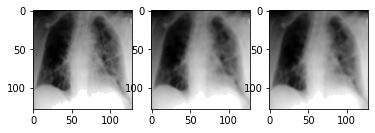

In [30]:
example_img_id = filtered_df['image_id'][0]
f, axarr = plt.subplots(1,3)
axarr[0].imshow(cv2.imread(f'{raw_128_dir}/bf1/{example_img_id}'), cmap='gray')
axarr[1].imshow(cv2.imread(f'{raw_128_dir}/bf2/{example_img_id}'), cmap='gray')
axarr[2].imshow(cv2.imread(f'{raw_128_dir}/bf3/{example_img_id}'), cmap='gray')
plt.show()

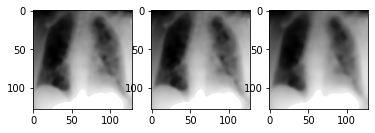

In [31]:
example_img_id = filtered_df['image_id'][0]
f, axarr = plt.subplots(1,3)
axarr[0].imshow(cv2.imread(f'{raw_128_dir}/bf4/{example_img_id}'), cmap='gray')
axarr[1].imshow(cv2.imread(f'{raw_128_dir}/bf5/{example_img_id}'), cmap='gray')
axarr[2].imshow(cv2.imread(f'{raw_128_dir}/bf6/{example_img_id}'), cmap='gray')
plt.show()

Guardo los path de las imágenes en un csv para utilizarlos en otros notebooks.

In [32]:
# Save index to csv
filtered_df.to_csv(processed_csv_path)


Observo como era una imágen originalmente.

Imagen original


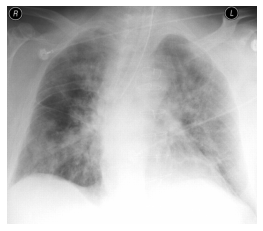

In [33]:
print('Imagen original')
plt.imshow(cv2.imread(f'{raw_dir}/{example_img_id}'), cmap='gray')
plt.axis('off')
plt.show()

Observo como es una imágen procesada.

Imagen resultante


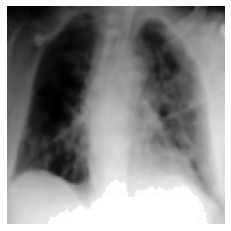

In [34]:
print('Imagen resultante')
plt.imshow(cv2.imread(f'{raw_128_dir}/bf1/{example_img_id}'), cmap='gray')
plt.axis('off')
plt.show()

In [36]:
!jupyter nbconvert --to html preprocessing.ipynb

[NbConvertApp] Converting notebook preprocessing.ipynb to html
[NbConvertApp] Writing 888841 bytes to preprocessing.html
